In [1]:
#| default_exp fid

Set the `max_split_size_mb` for cuda allocations. This reduces wasted allocated but unused space. Without it, there were issues getting the inception model to run with a good batch size, even on a 24G VRAM card

Not necessary if more VRAM is available

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# FID

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Classifier

In [42]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) * 2 - 1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [43]:
b = xb, yb = next(iter(dls.train))

load the model locally or from GFS

In [4]:
model = torch.load('../models/data_aug2.pkl', map_location=torch.device(def_device))

In [7]:
import gcsfs

def torch_load_from_gcs(GFS_PROJECT, GFS_PATH, TOKEN, device='cpu'):
    fs = gcsfs.GCSFileSystem(project=GFS_PROJECT, token=TOKEN)
    with fs.open(GFS_PATH, 'rb') as f:
        return torch.load(f, map_location=torch.device(device))

In [6]:
import os

GFS_PROJECT = <PROJECT>
GFS_PATH = <PATH> '/data_aug2.pkl'

# TOKEN = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
TOKEN = <PATH TO SERVICE/USER CREDENTIALS JSON>
   
model = torch_load_from_gcs(GFS_PROJECT, GFS_PATH, TOKEN, def_device)


In [5]:
cbs = [DeviceCB(), MixedPrecision()] if def_device != 'cpu' else [DeviceCB(), TrainCB()]
# cbs = [DeviceCB(), MixedPrecision()]
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)

In [8]:
def append_outp(hook, mod, inp, outp):
    # import pdb; pdb.set_trace()
    if not hasattr(hook,'outp'): hook.outp = []
    hook.outp.append(to_cpu(outp))

In [9]:
hcb = HooksCallback(append_outp, mods=[learn.model[6]], on_valid=True)

In [10]:
learn.fit(1, train=False, valid=True, cbs=[hcb])

In [11]:
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

In [6]:
del(learn.model[8])
del(learn.model[7])

In [8]:
feats, y = learn.capture_preds()
feats = feats.float()
feats.shape, y

(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

# Calc FID

In [8]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [9]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=fc.defaults.cpus)

In [10]:
dls2 = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [11]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [17]:
# smodel = torch.load('../models/fashion_ddpm_mp.pkl', map_location=torch.device(def_device))

GFS_PROJECT = <PROJECT>
GFS_PATH = <PATH> '/fashion_ddpm_mp.pkl'
TOKEN = <PATH TO SERVICE/USER CREDENTIALS JSON>
smodel = torch_load_from_gcs(GFS_PROJECT, GFS_PATH, TOKEN, device=def_device)

In [25]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        alphabar_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        betabar_t = 1 - alphabar[t]
        betabar_t1 = 1 - alphabar_t1
        x_0_hat = ((x_t - betabar_t.sqrt() * model((x_t, t_batch))) / alphabar[t].sqrt())
        x_t = x_0_hat * alphabar_t1.sqrt() * (1 - alpha[t]) / betabar_t + x_t * alpha[t].sqrt() * betabar_t1 / betabar_t + sigma[t] * z
        preds.append(x_0_hat.cpu())
    return preds

In [18]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_0_hat.cpu())
    return preds

In [19]:
%%time
samples = sample(smodel, (256, 1, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 43.9 s, sys: 1.41 s, total: 45.4 s
Wall time: 45.4 s


In [20]:
s = samples[-1] * 2 - 1

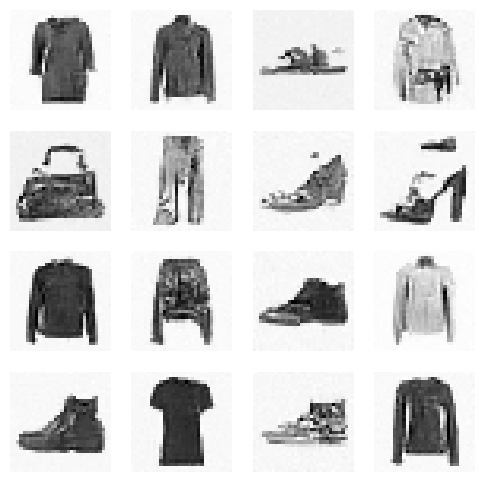

In [21]:
show_images(s[:16], imsize=1.5)

In [28]:
del(smodel)
torch.cuda.empty_cache()

In [31]:
clearn = TrainLearner(model, DataLoaders([], [(s, yb)]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats2, y2 = clearn.capture_preds()
feats2 = feats2.float().squeeze()
feats2.shape

torch.Size([256, 512])

In [32]:
means = feats.mean(0)
means.shape

torch.Size([512])

In [33]:
covs = feats.T.cov()
covs.shape

torch.Size([512, 512])

In [29]:
#|export
def _sqrtm_newton_schulz(mat, num_iters=100):
    mat_nrm = mat.norm()
    mat = mat.double()
    Y = mat/mat_nrm
    n = len(mat)
    I = torch.eye(n, n).to(mat)
    Z = torch.eye(n, n).to(mat)

    for i in range(num_iters):
        T = (3*I - Z@Y)/2
        Y,Z = Y@T,T@Z
        res = Y*mat_nrm.sqrt()
        if ((mat-(res@res)).norm()/mat_nrm).abs()<=1e-6: break
    return res

In [30]:
def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0), feats.T.cov()

def _calc_fid(m1, c1, m2, c2):
    # csr = _sqrtm_newton_schulz(c1@c2)
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1 - m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

In [36]:
s1, s2 = _calc_stats(feats), _calc_stats(feats2)

In [37]:
_calc_fid(*s1, *s2)

46.6240234375

In [31]:
#|export
def _squared_mmd(x, y):
    def k(a,b): return (a@b.transpose(-2,-1)/a.shape[-1]+1)**3
    m,n = x.shape[-2],y.shape[-2]
    kxx,kyy,kxy = k(x,x), k(y,y), k(x,y)
    kxx_sum = kxx.sum([-1,-2])-kxx.diagonal(0,-1,-2).sum(-1)
    kyy_sum = kyy.sum([-1,-2])-kyy.diagonal(0,-1,-2).sum(-1)
    kxy_sum = kxy.sum([-1,-2])
    return kxx_sum/m/(m-1) + kyy_sum/n/(n-1) - kxy_sum*2/m/n

In [32]:
#|export
def _calc_kid(x, y, maxs=50):
    xs,ys = x.shape[0],y.shape[0]
    n = max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.
    for i in range(n):
        cur_x = x[round(i*xs/n) : round((i+1)*xs/n)]
        cur_y = y[round(i*ys/n) : round((i+1)*ys/n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

In [43]:
_calc_kid(feats, feats2)

0.26407089829444885

## FID class

In [33]:
#|export
class ImageEval:
    def __init__(self, model, dls, cbs=None):
        self.learn = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn.capture_preds()[0].float().cpu().squeeze()
        self.stats = _calc_stats(self.feats)

    def get_feats(self, samp):
        self.learn.dls = DataLoaders([],[(samp, tensor([0]))])
        return self.learn.capture_preds()[0].float().cpu().squeeze()

    def fid(self, samp): return _calc_fid(*self.stats, *_calc_stats(self.get_feats(samp)))
    def kid(self, samp): return _calc_kid(self.feats, self.get_feats(samp))

In [17]:
ie = ImageEval(model, learn.dls, cbs=[DeviceCB()])

In [57]:
%%time
ie.fid(s)

CPU times: user 480 ms, sys: 3.65 ms, total: 484 ms
Wall time: 262 ms


46.6728515625

In [58]:
%%time
ie.kid(s)

CPU times: user 240 ms, sys: 0 ns, total: 240 ms
Wall time: 126 ms


0.2645728588104248

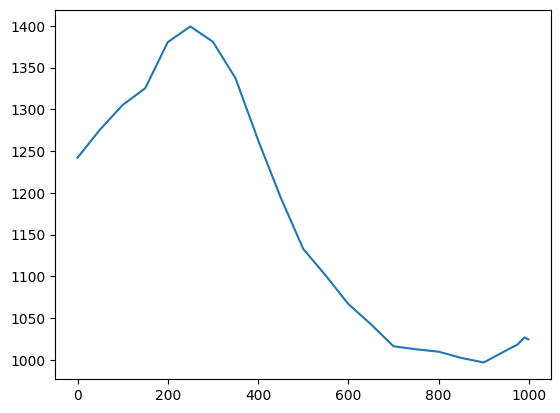

In [59]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.fid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

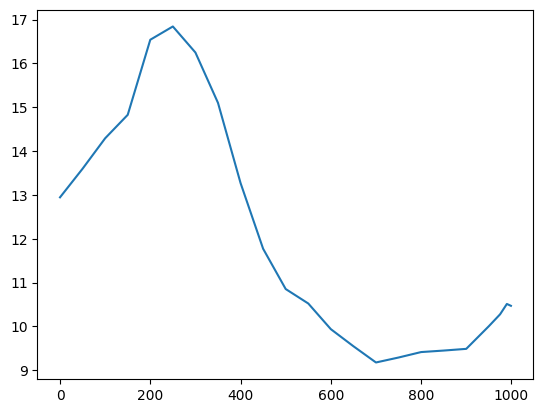

In [60]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.kid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

In [62]:
ie.fid(xb)

5.601318359375

In [64]:
ie.kid(xb)

-0.019449234008789062

## Inception

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [ ]:
# !pip install pytorch-fid

In [35]:
from pytorch_fid.inception import InceptionV3

In [11]:
a = tensor([1,2,3])
a.repeat((3,1))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [36]:
class IncepWrap(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = InceptionV3(resize_input=True)
    def forward(self, x): return self.m(x.repeat((1,3,1,1)))[0]

In [38]:
tds = dsd.with_transform(transformi)
# dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)

In [39]:
ie = ImageEval(IncepWrap(), dls, cbs=[DeviceCB()])

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/dom/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 235MB/s]


Compare fid and kid from samples to a batch in the dataset

In [40]:
%%time
ie.fid(s)

CPU times: user 10.8 s, sys: 528 ms, total: 11.4 s
Wall time: 6.82 s


61.865264892578125

In [44]:
ie.fid(xb)

27.351043701171875

In [45]:
%%time
ie.kid(s)

CPU times: user 1.06 s, sys: 15.9 ms, total: 1.08 s
Wall time: 829 ms


0.011196414940059185

In [46]:
ie.kid(xb)

-4.120306402910501e-05